In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import scipy.integrate

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Functions to generate the trajectories

In [38]:
e3 = np.array([0,0,1])

In [39]:
def Massm(nop,m):
  """
  Mass matrix Mij defining the kinetic energy T=sum_ij dotqiT Mij dotqj
  n size of the matrix
  m masses of the pendulums (supposed to be all the same in this case)
  """
  M=np.zeros((nop,nop))
  for i in range(nop):
    M[i,i]=(nop-i)*m
    for j in range(i):
      M[i,j] = (nop-i)*m
    for k in range(i):
      M[k,i]=M[i,j]

  return M


#Isomorphism between R3 and so(3)
def hat(q):
  return np.array([[0.,-q[2],q[1]],[q[2],0.,-q[0]],[-q[1],q[0],0.]])


In [40]:
def MatrR(q):
  m = 1.
  L = 1.
  n = len(q)
  nn = int(n/3)
  M=Massm(nn,m)
  R = M[0,0]*np.eye(3)
  for j in range(1,nn):
        R = np.concatenate((R,M[0,j]*(np.eye(3)-np.outer(q[0:3],q[0:3]))), axis=1)
  for i in range(1,nn):
    for j in range(nn):
      if j in [i]:
        R = np.concatenate((R,M[i,i]*np.eye(3)), axis=1)
      else:
        R = np.concatenate((R,M[i,j]*(np.eye(3)-np.outer(q[3*i:3*i+3],q[3*i:3*i+3]))), axis=1)
  row=R[0:3,0:n]
  for i in range(1,nn):
    row = np.concatenate((row,R[0:3,n*i:n*i+n]), axis=0)
  return row

Derivatives of the Hamiltonian

In [41]:
def Hp(z): 
  nop = int(len(z)/6)
  q = z[0:3]
  p = z[3:6]
  for i in range(1,nop):
    q = np.concatenate((q,z[3*(2*i):3*(2*i+1)]))
    #print('q=',q)
    p = np.concatenate((p,z[3*(2*i+1):3*(2*i+2)]))
    #print('p=',p)
  return 0.5 * np.linalg.solve(MatrR(q),p) + 0.5 * np.linalg.solve(MatrR(q).T,p)

def Hq(z):
  nop = int(len(z)/6)
  g = 1
  m = 1
  L = 1
  q = z[0:3]
  p = z[3:6]
  for i in range(1,nop):
    q = np.concatenate((q,z[3*(2*i):3*(2*i+1)]))
    p = np.concatenate((p,z[3*(2*i+1):3*(2*i+2)]))
  func = lambda v: np.dot(p,np.linalg.solve(MatrR(v),p))
  nablaq = grad(func)
  nablaqq = nablaq(q)  
  res = m*g*L*e3*nop
  for j in range (2,nop+1):
    res = np.concatenate((res, (nop-j+1)*m*L*g*e3))
  return 0.5*nablaqq + res

In [42]:
T = 0.1 #final time
M = 5 #number of time steps
time = np.linspace(0,T,M)
dt = time[1] - time[0]
s = 3 # dimensionality of the problem (dynamics with ambient space R^2s)
N = 500 #number of initial conditions

nop = 2 #Number of pundulums

Definition of the Hamiltonian vector field of interest

In [43]:
def dynamics(t,z):
  nop = int(len(z)/6)
  vec = 0*z
  I = np.eye(3)

  q = z[0:3]
  p = z[3:6] 
  vec[:3] = (I-np.outer(q,q))@Hp(z)[:3]
  vec[3:6] = -(I-np.outer(q,q))@Hq(z)[:3] + np.cross(Hp(z)[:3],np.cross(p,q))

  for i in range(1,nop):
    q = z[3*(2*i):3*(2*i+1)]
    p = z[3*(2*i+1):3*(2*i+2)] 
    vec[3*(2*i):3*(2*i+1)]= (I-np.outer(q,q))@Hp(z)[3*i:3*(i+1)]
    vec[3*(2*i+1):3*(2*i+2)] = -(I-np.outer(q,q))@Hq(z)[3*i:3*(i+1)] + np.cross(Hp(z)[3*i:3*(i+1)],np.cross(p,q))

  return vec

# Generating training and test trajectories with ODE45

In [44]:
trajectories = np.zeros([N,2*s*nop,M])

#Generate the initial conditions

q = np.zeros(int(3*nop))
p = np.zeros(int(3*nop))

for i in range(N):
  for j in range(nop):
    nrand = np.random.randn(3)
    q = nrand/np.linalg.norm(nrand,2)
    trajectories[i,3*2*j:3*(2*j+1),0] = q 
    supp = np.random.rand(3)
    trajectories[i,3*(2*j+1):3*(2*j+2),0] = np.cross(q,supp)


#Generate the dataset
for j in range(N):
  trajectories[j,:,:] = scipy.integrate.solve_ivp(dynamics,[0,T],trajectories[j,:,0],method='RK45',t_eval = time,rtol=1e-3,atol=1e-5).y

In [45]:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

a = 1 * np.outer(np.cos(u), np.sin(v))
b = 1 * np.outer(np.sin(u), np.sin(v))
c = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

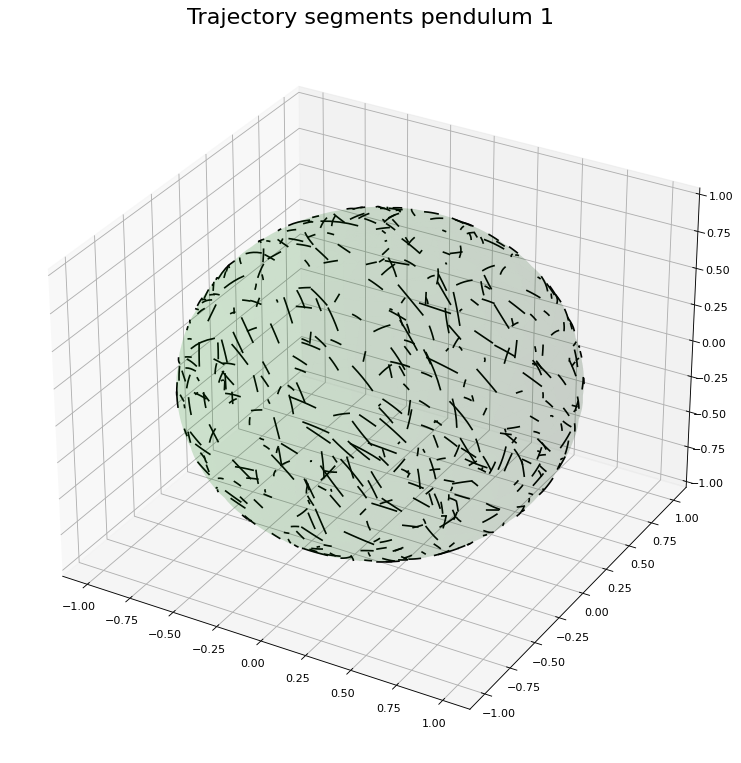

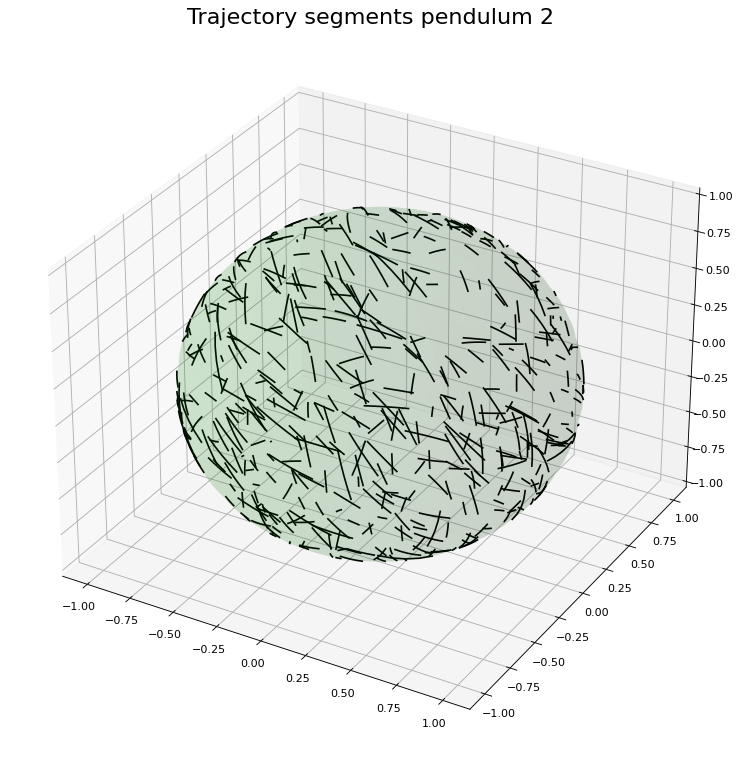

In [46]:
for num in range(nop):
  fig = plt.figure(figsize=(12,12), dpi=80)
  ax = plt.axes(projection='3d')
  ax.plot_surface(a, b, c,  rstride=4, cstride=4, color='g', linewidth=0, alpha=0.09)
  for i in range(N):
    ax.plot3D(trajectories[i,6*num,:],trajectories[i,6*num+1,:],trajectories[i,6*num+2,:],'k-')
  plt.title(f"Trajectory segments pendulum {num+1}",fontsize=20)
  plt.show()

In [47]:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

# Building the neural network

In [48]:
X = trajectories[:,:,0]
Y = trajectories[:,:,1:M+1]

In [49]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X,Y)

In [50]:
batch_size = 80
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

In [51]:
K = 100 #number of neurons of the hidden layers for the potential energy
nlayers = 2

In [52]:
id1=np.arange(0,s*nop,s)
id2=np.arange(1,s*nop,s)
id3=np.arange(2,s*nop,s)

In [53]:
class Hamiltonian(nn.Module):
    def __init__(self, ):
        super(Hamiltonian, self).__init__()
        
        self.IV = nn.Linear(s*nop,K) 
        self.nl = nn.Tanh()
        self.OV = nn.Linear(K,1,bias=False)

        ll = []
        ll.append(self.IV)
        ll.append(self.nl)
        for i in range(nlayers):
          ll.append(nn.Linear(K,K))
          ll.append(self.nl)
        ll.append(self.OV)

        self.seq = nn.Sequential(*ll)

        self.Gamma = torch.nn.Parameter(data=torch.rand(nop,nop))
        self.B = torch.nn.Parameter(data=torch.rand(nop))
        self.func = nn.ReLU()

    #Definition of the mass matrix
    def MassMat(self,X):
      nop = int(X.size(dim=1)/6)
      q = X[:,:3]
      for j in range(1,nop):
        q = torch.cat([q, X[:,3*2*j:3*(2*j+1)]], axis=1)
      M = torch.transpose(self.Gamma,0,1)@self.Gamma + torch.diag(self.B)
      I = torch.eye(3).unsqueeze(0).repeat(len(q),1,1).to(device)
      R = M[0,0] * I
      for j in range(1,nop):
        R = torch.cat((R,M[0,j]*(I-torch.einsum('ij,ik->ijk',q[:,:3],q[:,:3]))),axis=2)
      for i in range(1,nop):
        for j in range(nop):
          if j == i:
            R = torch.cat((R,M[i,i]*I),axis=2)
          else:
            R = torch.cat((R,M[i,j]*(I-torch.einsum('ij,ik->ijk',q[:,3*i:3*i+3],q[:,3*i:3*i+3]))),axis=2)
      n = nop * s
      row=R[:,0:3,0:n]
      for i in range(1,nop):
        row = torch.cat((row,R[:,0:3,n*i:n*(i+1)]),axis=1)
      return row

    #Modelling of the Kinetic energy as a bilinear form  
    def Kinetic(self, X):
        nop = int(X.size(dim=1)/6)
        id = torch.eye(nop,nop)
        ref = torch.ones(3,3)
        R = torch.kron(id, ref).to(device)
        U = torch.ones(3*nop,3*nop).to(device)
        p = X[:,3:6]
        for j in range(1,nop):
          p = torch.cat([p, X[:,3*(2*j+1):3*(2*j+2)]], axis=1)
        MM = self.MassMat(X) 
        k = (0.5 * torch.einsum('ij,ij->i',p,torch.linalg.solve(MM,p))).unsqueeze(1) #q dependent component
        return k
    
    #Modelling of the potential energy as a feed-forward neural network
    def Potential(self, X):
        nop = int(X.size(dim=1)/6)
        q = X[:,:3]
        for j in range(1,nop):
          q = torch.cat([q, X[:,3*2*j:3*(2*j+1)]], axis=1)

        v = self.seq(q)
        
        return v

    #Sum of the contributions to get the approximated Hamiltonian energy
    def forward(self, X):
        o = self.Potential(X) + self.Kinetic(X)
        return o

In [54]:
Ham = Hamiltonian()
Ham.to(device)

Hamiltonian(
  (IV): Linear(in_features=6, out_features=100, bias=True)
  (nl): Tanh()
  (OV): Linear(in_features=100, out_features=1, bias=False)
  (seq): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=1, bias=False)
  )
  (func): ReLU()
)

In [55]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Ham.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training Neural Network

### Methods required for Lie group integrators

In [56]:
def hatNN(q):
  zz = torch.zeros([len(q),1]).to(device)  #len(q) numero punti nel batch
  row1 = torch.cat([zz,-q[:,2:3],q[:,1:2]],axis=1).unsqueeze(1).to(device)
  row2 = torch.cat([q[:,2:3],zz,-q[:,0:1]],axis=1).unsqueeze(1).to(device)
  row3 = torch.cat([-q[:,1:2],q[:,0:1],zz],axis=1).unsqueeze(1).to(device)
  res = torch.cat([row1,row2,row3],axis=1).to(device) # 3d tensor
  return res

def fManiAlgebraNN(H,z):

  nop = z.size(dim=1)//6
  HamVal = torch.sum(H(z)).to(device)
  dH = torch.autograd.grad(HamVal, z, create_graph=True)[0].to(device)

  q = z[:,0:3]
  p = z[:,3:6]
  dHq = dH[:,0:3]
  dHp = dH[:,3:6]
  xi = torch.cross(q,dHp)
  eta = torch.cross(dHq,q)+torch.cross(dHp,p)
  ff = torch.cat([xi,eta],axis=1).to(device)

  for i in range(1,nop):
    q = z[:,3*(2*i):3*(2*i+1)]
    p = z[:,3*(2*i+1):3*(2*i+2)]
    dHq = dH[:,3*(2*i):3*(2*i+1)]
    dHp = dH[:,3*(2*i+1):3*(2*i+2)]
    xi = torch.cross(q,dHp)
    eta = torch.cross(dHq,q)+torch.cross(dHp,p)
    ff = torch.cat([ff,xi,eta],axis=1)

  return ff


def expso3NN(x):
  a = torch.linalg.norm(x,axis=1).to(device)
  tol = 10**(-10)
  aa = ((a>=tol)*1)
  dd = ((a>0)*1)*((a<tol)*1)
  expA = torch.eye(3).unsqueeze(0).repeat(len(x),1,1).to(device)
  cc = aa.nonzero(as_tuple=True)
  #if a>tol:
  A = torch.zeros(len(expA)).to(device)
  B = torch.zeros(len(expA)).to(device)
  A[cc] = (torch.div(torch.sin(a[cc]),a[cc]))
  B[cc] = ((1-torch.cos(a[cc]))/a[cc]**2)

  expA += torch.einsum('i,ijk->ijk',A,hatNN(x)) + torch.einsum('i,ijk->ijk',B,torch.einsum('ijk,ikl->ijl',hatNN(x),hatNN(x)))

  #if a>0 and a<tol:
  mult1 = 1 * dd
  mult2 = 1/2 * dd
  mult3 = 1/6 * dd
  mult4 = 1/24 * dd

  pow1 = hatNN(x)
  
  pow2 = (torch.einsum('ijk,ikl->ijl',pow1,pow1))
  pow3 = (torch.einsum('ijk,ikl->ijl',pow2,pow1))
  pow4 = (torch.einsum('ijk,ikl->ijl',pow3,pow1))
  

  expA += torch.einsum('i,ijk->ijk',mult1,pow1) + torch.einsum('i,ijk->ijk',mult2,pow2) + torch.einsum('i,ijk->ijk',mult3,pow3) + torch.einsum('i,ijk->ijk',mult4,pow4)
  return expA

def expse3NN(input):
  u = input[:,:3]
  v = input[:,3:]
  a = torch.linalg.norm(u,axis=1).to(device)
  tol = 1e-10;  

  cc = a>=tol + 0
  ee = (a<tol)*(a>0) + 0

  V = torch.eye(3).unsqueeze(0).repeat(len(input),1,1).to(device) #the right matrix if a = 0, then we increment with the right quantities 

  #if a>tol:
  A = cc*(torch.div(torch.sin(a),a))
  B = cc*((1-torch.cos(a))/a**2)
  C = cc*(torch.div(1-A,a**2))

  V += torch.einsum('i,ijk->ijk',B,hatNN(u)) + torch.einsum('i,ijk->ijk',C,torch.einsum('ijk,ikl->ijl',hatNN(u),hatNN(u)))
  
  #if 0<a<tol:
  Blow = ee*(0.5-a**2/24 + a**4/720 - a**6/40320)
  Clow = ee*(1/6-a**2/120+a**4/5040-a**6/362880)
  V += torch.einsum('i,ijk->ijk',Blow,hatNN(u)) + torch.einsum('i,ijk->ijk',Clow,torch.einsum('ijk,ikl->ijl',hatNN(u),hatNN(u)))

  expA = torch.cat([expso3NN(u), torch.einsum('ijk,ik->ij',V,v).unsqueeze(2)],axis=2).to(device)

  return expA


def expse3NNn(input):
  dim0 = input.size(dim=0)
  dim1 = input.size(dim=1)
  nop = int(dim1/6)
  out = expse3NN(input[:,0:6])
  for i in range(1,nop):
    out = torch.cat([out, expse3NN(input[:,6*i:6*(i+1)])], axis=2).to(device)
  return out


def actionSE3NN(g, z):
  R = g[:,:,:3]
  r = g[:,:,3]
  q = z[:,0:3]
  p = z[:,3:]
  qq = torch.einsum('ijk,ik->ij',R,q)
  pp = torch.einsum('ijk,ik->ij',R,p) + torch.einsum('ijk,ik->ij',hatNN(r),qq)
  return torch.cat([qq,pp],axis=1).to(device)


def actionse3NNn(g, z):
  dim0 = z.size(dim=0)
  dim1 = z.size(dim=1)
  nop = int(dim1/6)
  out = actionSE3NN(g[:,:,0:4],z[:,0:6])
  for i in range(1,nop):
     out = torch.cat([out, actionSE3NN(g[:,:,4*i:4*(i+1)],z[:,6*i:6*(i+1)])], axis=1).to(device)
  return out

In [57]:
def LieEulerNN(x0,f,h,cc,H):   # cc = M-1
  num = len(x0) #number of points
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0
  times = 1
  h = h/times
  for i in range(cc):
    for j in range(times):
      z =  actionse3NNn(expse3NNn(h*f(H,z)),z)
    sol[:,:,i] = z
  return sol

In [58]:
def CF4NN(x0,f,h,cc,H):

  num = len(x0) #number of points
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0
  times = 2
  h = h/times
  for i in range(cc):
    for j in range(times):
      M1 = z
      A1 = f(H,M1)
      M2 = actionse3NNn(expse3NNn(0.5*h*A1),z)
      A2 = f(H,M2)
      M3 = actionse3NNn(expse3NNn(0.5*h*A2),z)
      A3 = f(H,M3)
      M4 = actionse3NNn(expse3NNn(h*A3-0.5*h*A1),M2)
      A4 = f(H,M4)
      mhalf = actionse3NNn(expse3NNn(1/12*h*(3*A1+2*A2+2*A3-A4)),z)  
      z = actionse3NNn(expse3NNn(1/12*h*(-A1+2*A2+2*A3+3*A4)),mhalf)
    sol[:,:,i] = z

  return sol

### Classical Runge-Kutta integrators

In [59]:
#Characterization of the Hamiltonian vector field with Hamiltonian given by HH
def predictedVF(x,HH):
  z = x.clone().requires_grad_().to(device)
  nop = int(len(z[0])/6)
  HamVal = torch.sum(HH(z)) #H sarà la rete ...fatto per prendere il gradiente
  dH = torch.autograd.grad(HamVal, z, create_graph=True)[0]

  vec = torch.zeros(z.shape).to(device)
  q = z[:,0:3]
  p = z[:,3:6]
  dHq = dH[:,:3]
  dHp = dH[:,3:6]
  for i in range(1,nop):
    q = torch.concat((q,z[:,3*(2*i):3*(2*i+1)]),dim=1)
    p = torch.concat((p,z[:,3*(2*i+1):3*(2*i+2)]),dim=1)
    dHq = torch.concat((dHq,dH[:,3*(2*i):3*(2*i+1)]),dim=1)
    dHp = torch.concat((dHp,dH[:,3*(2*i+1):3*(2*i+2)]),dim=1)

  I = torch.eye(3).repeat(len(z),1,1).to(device)
  #part for the first pendulum
  
  for i in range(nop):
    mat1 = (I-torch.einsum('ij,ik->ijk',q[:,3*i:3*(i+1)],q[:,3*i:3*(i+1)]))
    dqdt = torch.einsum('ijk,ik->ij',mat1,dHp[:,3*i:3*(i+1)])
    part1 = -torch.einsum('ijk,ik->ij',mat1,dHq[:,3*i:3*(i+1)])
    part2 = torch.cross(dHp[:,3*i:3*(i+1)],torch.cross(p[:,3*i:3*(i+1)],q[:,3*i:3*(i+1)]))
    dpdt = part1 + part2
    vec[:,6*i:6*(i+1)] = torch.concat([dqdt,dpdt],dim=1)

  return vec

In [60]:
def RK4(x0,h,cc,H):
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0.clone().requires_grad_()
  for i in range(cc):
    k1 = predictedVF(z,H) 
    k2 = predictedVF(z + 0.5 * h * k1, H)
    k3 = predictedVF(z + 0.5 * h * k2, H)
    k4 = predictedVF(z + h * k3, H)
    z = z + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)
    sol[:,:,i] = z.to(device)
  return(sol) #stored trajectories

def ExpEuler(x0,h,cc,H):
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0.clone()
  z.requires_grad_()
  for i in range(cc):
    z = z + h * predictedVF(z,H) 
    sol[:,:,i] = z.to(device)
  
  return(sol) #stored trajectories

### Training of the network

In [61]:
#Choice of the integrator
integrator = CF4NN
isLieGroupMethod = True #is integrator a Lie group method?

In [62]:
checkpoint = 20

for epoch in range(100):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs.requires_grad_()
        optimizer.zero_grad()

        if isLieGroupMethod:
          predicted = integrator(inputs,fManiAlgebraNN,dt,M-1,Ham)
        else:
          predicted = integrator(inputs,dt,M-1,Ham)

        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % checkpoint == 0:  
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / checkpoint))
            running_loss = 0.0

    scheduler.step()
    if epoch%10 == 0 and epoch>0:
      lr=optimizer.param_groups[0]["lr"]
      print(f"\n\nLR: {lr}, EPOCH: {epoch}\n\n")

print('Finished Training')

[1,     1] loss: 0.0000967351
[2,     1] loss: 0.0000316430
[3,     1] loss: 0.0000199274
[4,     1] loss: 0.0000153731
[5,     1] loss: 0.0000062981
[6,     1] loss: 0.0000026260
[7,     1] loss: 0.0000014247
[8,     1] loss: 0.0000004846
[9,     1] loss: 0.0000002108
[10,     1] loss: 0.0000001095
[11,     1] loss: 0.0000000715


LR: 0.01, EPOCH: 10


[12,     1] loss: 0.0000000457
[13,     1] loss: 0.0000000261
[14,     1] loss: 0.0000000231
[15,     1] loss: 0.0000000232
[16,     1] loss: 0.0000000169
[17,     1] loss: 0.0000000139
[18,     1] loss: 0.0000000139
[19,     1] loss: 0.0000000100
[20,     1] loss: 0.0000000095
[21,     1] loss: 0.0000000078


LR: 0.01, EPOCH: 20


[22,     1] loss: 0.0000000067
[23,     1] loss: 0.0000000067
[24,     1] loss: 0.0000000072
[25,     1] loss: 0.0000000067
[26,     1] loss: 0.0000000057
[27,     1] loss: 0.0000000038
[28,     1] loss: 0.0000000041
[29,     1] loss: 0.0000000044
[30,     1] loss: 0.0000000041
[31,     1] loss: 0.0000000031


# Evaluating the approximation

In [71]:
0.0000000016

1.6e-09

In [63]:
Ham.eval(); #pass in evaluation mode

In [64]:
def predicted(t,z):
  z = torch.from_numpy(z.astype(np.float32)).requires_grad_()
  z = z.to(device)
  nop = int(len(z)/6)
  
  HamVal = torch.sum(Ham(z.view(1,-1))).to(device)
  dH = torch.autograd.grad(HamVal, z, create_graph=True)[0].detach().cpu().numpy()

  vec = np.zeros(len(z))
  z = z.detach().cpu().numpy()
  q = z[0:3]
  p = z[3:6]
  dHq = dH[:3]
  dHp = dH[3:6]
  for i in range(1,nop):
    q = np.concatenate((q,z[3*(2*i):3*(2*i+1)]))
    p = np.concatenate((p,z[3*(2*i+1):3*(2*i+2)]))
    dHq = np.concatenate((dHq,dH[3*(2*i):3*(2*i+1)]))
    dHp = np.concatenate((dHp,dH[3*(2*i+1):3*(2*i+2)]))

  I = np.eye(3)

  for i in range(nop):
    dqdt = (I-np.outer(q[3*i:3*(i+1)],q[3*i:3*(i+1)]))@dHp[3*i:3*(i+1)]
    part1 = -(I-np.outer(q[3*i:3*(i+1)],q[3*i:3*(i+1)]))@dHq[3*i:3*(i+1)]
    part2 = np.cross(dHp[3*i:3*(i+1)],np.cross(p[3*i:3*(i+1)],q[3*i:3*(i+1)]))
    dpdt = part1 + part2
    vec[6*i:6*(i+1)] = np.concatenate([dqdt,dpdt])
  return vec

Generate test initial conditions

In [65]:
MM = 15
TT = 1
Ntest = 100

predictedTraj = np.zeros([Ntest,2*s*nop,MM])
realTraj = np.zeros([Ntest,2*s*nop,MM])
timeEv = np.linspace(0,TT,MM)

In [66]:
q = np.zeros(int(3*nop))
p = np.zeros(int(3*nop))

for i in range(Ntest):
  for j in range(nop):
    nrand = np.random.randn(3)
    q = nrand/np.linalg.norm(nrand,2)
    predictedTraj[i,3*2*j:3*(2*j+1),0] = q #position # indici: i-esimo punto di dataset, coordinate vettore nello spazio di config, time step
    supp = np.random.rand(3)
    predictedTraj[i,3*(2*j+1):3*(2*j+2),0] = np.cross(q,supp)

realTraj[:,:,0] = predictedTraj[:,:,0]

In [67]:
#Generate the dataset
for j in range(Ntest):
  predictedTraj[j,:,:] = scipy.integrate.solve_ivp(predicted,[0,TT],predictedTraj[j,:,0],method='RK45',t_eval = timeEv,rtol=1e-6,atol=1e-8).y
  realTraj[j,:,:] = scipy.integrate.solve_ivp(dynamics,[0,TT],realTraj[j,:,0],method='RK45',t_eval = timeEv,rtol=1e-6,atol=1e-8).y

In [68]:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

a = 1 * np.outer(np.cos(u), np.sin(v))
b = 1 * np.outer(np.sin(u), np.sin(v))
c = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

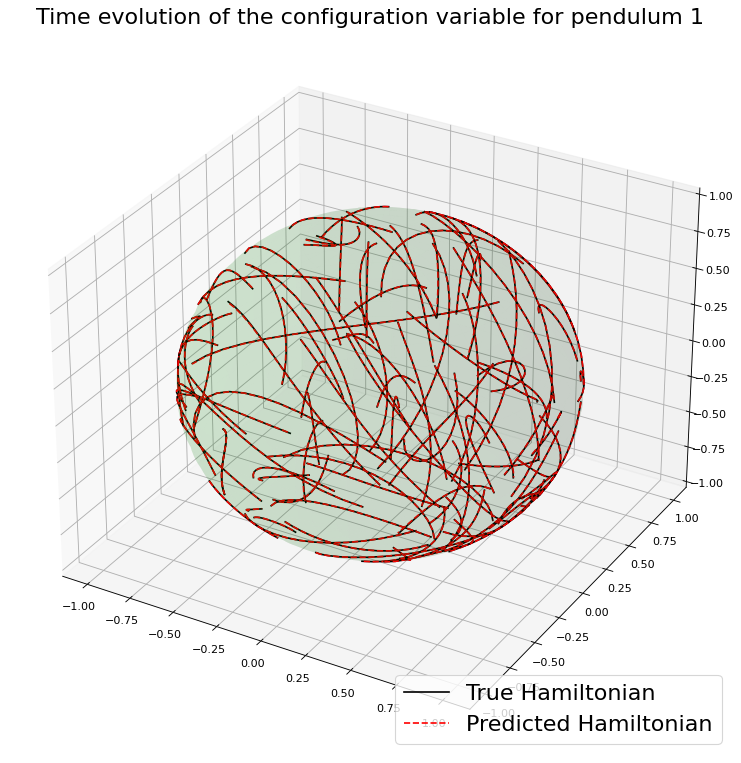

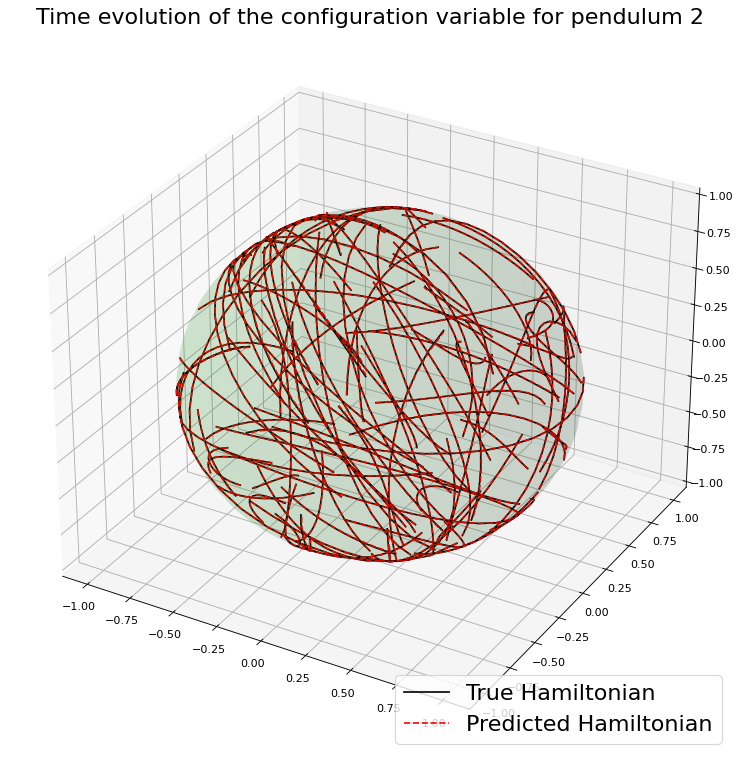

In [75]:
for num in range(nop):
  fig = plt.figure(figsize=(12,12), dpi=80)
  ax = plt.axes(projection='3d')
  ax.plot_surface(a, b, c,  rstride=4, cstride=4, color='g', linewidth=0, alpha=0.09)

  ax.plot3D(realTraj[0,6*num,:],realTraj[0,6*num+1,:],realTraj[0,6*num+2,:],'k-',label="True Hamiltonian")
  ax.plot3D(predictedTraj[0,6*num,:],predictedTraj[0,6*num+1,:],predictedTraj[0,6*num+2,:],'r--',label="Predicted Hamiltonian")
  for i in range(Ntest):
    ax.plot3D(realTraj[i,6*num,:],realTraj[i,6*num+1,:],realTraj[i,6*num+2,:],'k-')
    ax.plot3D(predictedTraj[i,6*num,:],predictedTraj[i,6*num+1,:],predictedTraj[i,6*num+2,:],'r--')
  plt.title(f"Time evolution of the configuration variable for pendulum {num+1}",fontsize=20)
  plt.legend(fontsize=20,loc='lower right')
  plt.show()

In [70]:
cc = np.mean((realTraj-predictedTraj)**2)
print("MSE on test trajectories with RK45 as integrator: ",cc)

MSE on test trajectories with RK45 as integrator:  2.6515254417509716e-06
